In [74]:
import numpy as np
import pandas, re, itertools
import matplotlib.pyplot as plt
from nltk import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.metrics import ContingencyMeasures
from nltk import BigramCollocationFinder
import nltk.collocations
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [111]:
#Функция из документации sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
df = pandas.read_csv('all_seasons.csv') #Открываю датасет. Я работал над датасетом, в котором убрал все переводы строк из цитат

In [25]:
#Выбираем данные, связанные с 4 главными героями
characters = df[(df.Character == 'Cartman') | (df.Character == 'Kenny') | (df.Character == 'Kyle') | (df.Character == 'Stan')]
characters.groupby('Character').describe() 

index
Character                    
Cartman   count   9774.000000
          mean   35263.191835
          std    20659.601559
          min        9.000000
          25%    18123.500000
          50%    35128.500000
          75%    53294.750000
          max    70722.000000
Kenny     count    881.000000
          mean   35397.415437
          std    17867.917673
          min       53.000000
          25%    21240.000000
          50%    37825.000000
          75%    46527.000000
          max    70422.000000
Kyle      count   7099.000000
          mean   36383.656149
          std    20072.800135
          min        1.000000
          25%    20926.000000
          50%    36350.000000
          75%    53317.500000
          max    70717.000000
Stan      count   7680.000000
          mean   38130.476823
          std    20034.048647
          min        0.000000
          25%    21894.250000
          50%    38407.000000
          75%    55571.750000
          max    70895.000000

In [ ]:
#Мало реплик Кенни. У остальных более-менее поровну. Не очень сбалансированная выборка получается.

In [33]:
#Обсценную лексику точно оставить, она может указывать на персонажа

In [109]:
#Инициализация count и tfidf векторизации
cvector = CountVectorizer(tokenizer=word_tokenize , stop_words="english")
tfidfvector = TfidfVectorizer(tokenizer=word_tokenize , stop_words="english")
#Инициализация аж пяти классификаторов
classifier_dc = DummyClassifier() 
classifier_dtc = DecisionTreeClassifier()
classifier_rfc = RandomForestClassifier()
classifier_lr = LogisticRegression()
classifier_nb = MultinomialNB()

#Массив классификаторов и их названий
classifiers = [[classifier_dc, "Dummy"], [classifier_dtc, "Decision Tree"], 
               [classifier_rfc, "Random Forest"], [classifier_lr, "Logistic Regression"], [classifier_nb, "Naive Bayes"]]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(data['Line'] , data['Character'], test_size=0.3) #Деление на выборки

In [106]:
#Векторизация count и tfidf
count_vector_train = cvector.fit_transform(X_train)
count_vector_test = cvector.transform(X_test)

tfidf_vector_train = tfidfvector.fit_transform(X_train)
tfidf_vector_test = tfidfvector.transform(X_test)

In [108]:
#Протестируем разные классификаторы на count и tfidf
#Отчет об успешности классификации + кросс валидация
for i in classifiers:
    print("\n" + i[1] + " method") 
    print("Count Vectorize")
    i[0].fit(count_vector_train, y_train)
    predict = i[0].predict(count_vector_test)
    print(classification_report(y_test, predict, target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))
    print("Cross Validation Score:", np.mean(cross_val_score(i[0], count_vector_train, y_train, cv=4)))
    
    print("-----------------------------------------------------------\n")
    print("TfIdf Vectorize")
    i[0].fit(tfidf_vector_train, y_train)
    predict = i[0].predict(tfidf_vector_test)
    print(classification_report(y_test, predict, target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))
    print("Cross Validation Score:", np.mean(cross_val_score(i[0], tfidf_vector_train, y_train, cv=4)))
    print("============================================================================================")
    print("============================================================================================")
    


Dummy method
Count Vectorize
             precision    recall  f1-score   support

    Cartman       0.40      0.40      0.40      2952
      Kenny       0.02      0.02      0.02       268
       Kyle       0.28      0.28      0.28      2129
       Stan       0.29      0.29      0.29      2282

avg / total       0.32      0.32      0.32      7631

Cross Validation Score: 0.31803604088
-----------------------------------------------------------

TfIdf Vectorize
             precision    recall  f1-score   support

    Cartman       0.39      0.38      0.38      2952
      Kenny       0.02      0.02      0.02       268
       Kyle       0.28      0.28      0.28      2129
       Stan       0.30      0.31      0.31      2282

avg / total       0.32      0.32      0.32      7631

Cross Validation Score: 0.319889216375

Decision Tree method
Count Vectorize
             precision    recall  f1-score   support

    Cartman       0.54      0.53      0.54      2952
      Kenny       0.97      0

In [ ]:
#Самый худший, очевидно, dummy. Если трех персонажей он худо-бедно определяет (ну хотя бы 30%), фраз Кенни он находит меньше 1%
#Забавно то, что у остальных четырех фразы Кенни получается искать с точностью 95 и более %
#Самый лучший классификатор получился на логистической регрессии с методом векторизации Count. 
#Точность и полнота у всех (кроме dummy) колеблется в районе нескольких процентов, но логистическая регрессия здесь тоже кажется оптимальным вариантом
#Логистическая регрессия определяет реплики персонажей примерно на 21-22% точнее

In [ ]:
#Посмотрим на сбалансированную регрессию

In [116]:
classifier_lrb = LogisticRegression(class_weight = 'balanced')
classifier_lrb.fit(count_vector_train, y_train)
predict = classifier_lr.predict(count_vector_test)
print(classification_report(y_test, predict, target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))
print("Cross Validation Score:", np.mean(cross_val_score(classifier_lrb, count_vector_train, y_train, cv=4)))

             precision    recall  f1-score   support

    Cartman       0.61      0.66      0.64      2952
      Kenny       0.96      0.96      0.96       268
       Kyle       0.47      0.36      0.41      2129
       Stan       0.45      0.50      0.47      2282

avg / total       0.54      0.54      0.53      7631

Cross Validation Score: 0.535752519249


In [ ]:
#Результат похуже

#Ради любопытства взглянем на tfidf:

In [117]:
classifier_lrb = LogisticRegression(class_weight = 'balanced')
classifier_lrb.fit(tfidf_vector_train, y_train)
predict = classifier_lr.predict(tfidf_vector_test)
print(classification_report(y_test, predict, target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))
print("Cross Validation Score:", np.mean(cross_val_score(classifier_lrb, tfidf_vector_train, y_train, cv=4)))

             precision    recall  f1-score   support

    Cartman       0.73      0.34      0.47      2952
      Kenny       0.97      0.64      0.77       268
       Kyle       0.42      0.33      0.37      2129
       Stan       0.38      0.73      0.50      2282

avg / total       0.55      0.47      0.46      7631

Cross Validation Score: 0.537043089342


In [114]:
#Все еще хуже самого первого выбранного варианта
#Таким образом, logistic regression + count оказывается лучшим вариантом

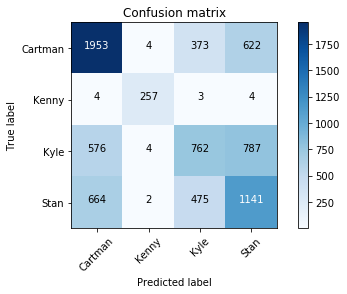

In [115]:
#Визуализация лучшего варианта
matrix = confusion_matrix(y_test, predict)
plt.figure()
plot_confusion_matrix(matrix, classes=['Cartman', 'Kenny' , 'Kyle' , 'Stan'])